In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import seaborn as sns
import numpy as np
import os


import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.patches as mpatches
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = "Arial" # missing fonts:: https://alexanderlabwhoi.github.io/post/2021-03-missingfont/
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 7, 'axes.linewidth': 1, 'xtick.major.width': 1, 'xtick.major.size': 4, 'ytick.major.width': 1, 'ytick.major.size': 4})
from matplotlib.backends.backend_pdf import PdfPages


In [2]:
def read_homer_motif_html(path, drop_logo_columns=True, coerce_numeric=True):
    """
    Parse a motif HTML results page into a pandas DataFrame.
    """
    with open(path, "r", encoding="utf-8") as f:
        soup = BeautifulSoup(f, "lxml")
    # Find the most likely results table (the one whose header contains 'Rank')
    tables = soup.find_all("table")
    if not tables:
        raise ValueError("No <table> found in the HTML file.")
    def header_cells(table):
        first = table.find("tr")
        return [] if first is None else [c.get_text(strip=True) for c in first.find_all(["th", "td"])]
    candidate = None
    headers = None
    for t in tables:
        hdr = header_cells(t)
        if hdr and any(h.lower().startswith("rank") for h in hdr):
            candidate, headers = t, hdr
            break
    if candidate is None:
        candidate, headers = tables[0], header_cells(tables[0])
    # Decide which columns to keep (drop logo/SVG if requested)
    drop_names = {"motif", "svg"} if drop_logo_columns else set()
    keep_idx = [i for i, h in enumerate(headers) if h.strip().lower() not in drop_names]
    keep_headers = [headers[i] for i in keep_idx]
    # Extract rows
    rows = []
    for tr in candidate.find_all("tr")[1:]:
        tds = tr.find_all("td")
        if not tds or len(tds) < len(headers):
            continue
        row = []
        for i in keep_idx:
            td = tds[i]
            head_lower = headers[i].strip().lower()
            # Prefer href for link-like columns
            a = td.find("a")
            if a and head_lower in {"motif file", "best match", "url", "link"}:
                row.append((a.get("href") or "").strip())
                continue
            # If there’s an inline SVG, blank it out (shouldn’t happen if dropped)
            if td.find("svg"):
                row.append("")
                continue
            # Otherwise collapse text cleanly
            text = " ".join(td.get_text(separator=" ", strip=True).split())
            row.append(text)
        rows.append(row)
    df = pd.DataFrame(rows, columns=keep_headers)
    # Optional numeric coercion (handles %, commas, scientific notation)
    if coerce_numeric:
        for col in df.columns:
            if df[col].dtype == object:
                s = df[col].str.replace("%", "", regex=False).str.replace(",", "", regex=False)
                # Try numeric; if it fails, keep as text
                converted = pd.to_numeric(s, errors="ignore")
                df[col] = converted
    # drop all na cols
    df = df.dropna(axis=1, how="all")
    return df

def save_pdf(save_file, fig):
    os.makedirs(os.path.dirname(save_file), exist_ok=True)
    pdf = PdfPages(save_file)
    pdf.savefig(fig, bbox_inches='tight', dpi=300)
    pdf.close()
    return


In [3]:
libnames = ["CC", "ATF2", "CTCF", "FOXA1", "LEF1", "SCRT1", "TCF7L2", "16P12_1"]

mea_df = []
resnet_df = []



for i,lib in enumerate(libnames[:-1]):
    ame_file = f"/data5/deepro/starrseq/papers/results/3_motif_enrichment_fragment_category/data/{lib}/homer/peaks_vs_notpeaks/knownResults.txt"
    ame_df = pd.read_csv(ame_file, sep="\t", skipfooter=4, usecols=["Motif Name", "q-value (Benjamini)"], engine="python")
    ame_df = ame_df.rename(columns=dict(zip(["Motif Name", "q-value (Benjamini)"], ["motif_ID", "adj_p-value"])))
    ame_df = ame_df.loc[ame_df["adj_p-value"]<0.05]
    ame_df["lib"] = lib
    mea_df.append(ame_df)

    html_file = f"/data5/deepro/starrseq/papers/results/4_ml_classification_fragment_category/data/{lib}/modisco_results/motifs.html"
    res_df = read_homer_motif_html(html_file)
    res_df = res_df.loc[res_df.groupby("match0")["qval0"].idxmin(), ["match0", "qval0"]]
    res_df = res_df.loc[res_df.qval0<0.05]
    res_df["lib"] = lib
    resnet_df.append(res_df)


mea_df = pd.concat(mea_df, axis=0)
resnet_df = pd.concat(resnet_df, axis=0)


<AxesSubplot:xlabel='lib', ylabel='motif_ID'>

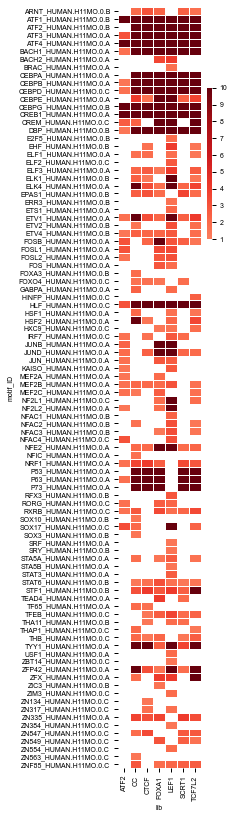

In [4]:
fig, axes = plt.subplots(1,1,figsize=(1.5,14))

ax = axes

mea_plot_df = mea_df.pivot(index="motif_ID", columns="lib", values="adj_p-value").replace(0, 1e-300).applymap(lambda x: -np.log10(x))
mea_plot_df = mea_plot_df.loc[mea_plot_df.notna().sum(axis=1)>0]


cbar_ax = fig.add_axes([0.95, 0.65, 0.05, 0.15])
sns.heatmap(
    mea_plot_df, vmin=1, center=2, vmax=10, 
    cmap="Reds", square=False, linewidth=0.5,
    cbar_ax=cbar_ax,
    ax=ax
    )

In [5]:
save_file = "/data5/deepro/starrseq/papers/results/4_ml_classification_fragment_category/data/figures/mea_top_motifs.pdf"
save_pdf(save_file, fig)

<AxesSubplot:xlabel='lib', ylabel='match0'>

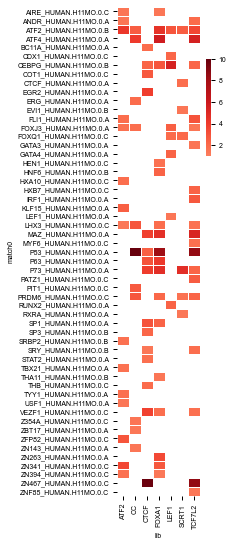

In [6]:
fig, axes = plt.subplots(1,1,figsize=(1.5,9))

ax = axes

resnet_plot_df = resnet_df.pivot(index="match0", columns="lib", values="qval0").replace(0, 1e-300).applymap(lambda x: -np.log10(x))
resnet_plot_df = resnet_plot_df.loc[resnet_plot_df.notna().sum(axis=1)>0]


cbar_ax = fig.add_axes([0.95, 0.65, 0.05, 0.15])
sns.heatmap(
    resnet_plot_df, vmin=1, center=2, vmax=10, 
    cmap="Reds", square=False, linewidth=0.5,
    cbar_ax=cbar_ax,
    ax=ax
    )

In [7]:
save_file = "/data5/deepro/starrseq/papers/results/4_ml_classification_fragment_category/data/figures/resnet_top_motifs.pdf"
save_pdf(save_file, fig)